## Load data

In [1]:
pip install dea_tools --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datacube
from datacube.utils.masking import mask_invalid_data
from dea_tools.dask import create_local_dask_cluster

dc = datacube.Datacube()

create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43671 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-notebooks/Testing/dask-worker-space/worker-lyab3718', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-notebooks/Testing/dask-worker-space/worker-3lpytw4g', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/43671/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/43671/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33325,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/43671/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:43773,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/32973/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:39171,


In [3]:
query_params = dict(
    product=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    x=(138.87, 138.89), 
    y=(-35.55, -35.57), 
    time=("2021", "2023")
)

load_params = dict(
    output_crs='epsg:32754',
    resolution=(-10, 10),
    group_by="solar_day",
    dask_chunks={},
    measurements=["oa_s2cloudless_prob", "oa_s2cloudless_mask", "oa_fmask"],
)


# Load data
ds = dc.load(**query_params, **load_params)

# Convert -999 to NaN
ds = mask_invalid_data(ds)

# Load into memory using Dask
ds.load()

<xarray.Dataset>
Dimensions:              (time: 149, y: 227, x: 187)
Coordinates:
  * time                 (time) datetime64[ns] 2021-01-01T00:46:58.906327 ......
  * y                    (y) float64 6.064e+06 6.064e+06 ... 6.062e+06 6.062e+06
  * x                    (x) float64 3.069e+05 3.069e+05 ... 3.088e+05 3.088e+05
    spatial_ref          int32 32754
Data variables:
    oa_s2cloudless_prob  (time, y, x) float64 0.1187 0.1187 ... 0.6029 0.6029
    oa_s2cloudless_mask  (time, y, x) float64 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0
    oa_fmask             (time, y, x) float64 1.0 1.0 5.0 5.0 ... 2.0 2.0 2.0
Attributes:
    crs:           epsg:32754
    grid_mapping:  spatial_ref

## Compare cloudiness according to Fmask and s2cloudless

Calculate what percent of each scene is cloud (value 2) according to Fmask:

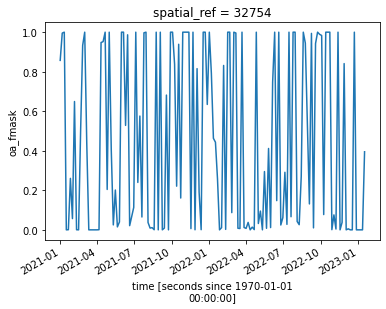

In [4]:
(ds["oa_fmask"] == 2).mean(dim=['x', 'y']).plot()

Calculate what percent of each scene is cloud (value 2) according to the s2cloudless mask.

Note the large several month period from 2022-01 to 2022-12 where we have no scenes with less than ~50% cloud:

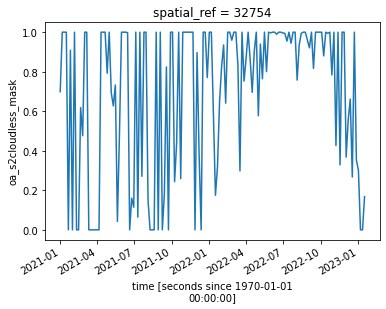

In [5]:
(ds["oa_s2cloudless_mask"] == 2).mean(dim=['x', 'y']).plot()

We can also calculate the average s2cloudless cloud probabilities per scene. This shows a similar pattern:

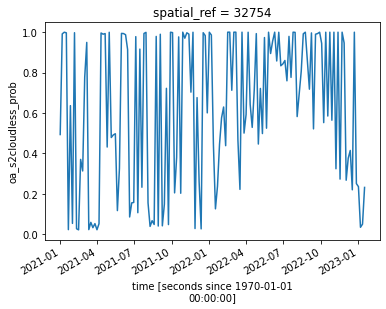

In [6]:
ds["oa_s2cloudless_prob"].mean(dim=['x', 'y']).plot()

Calculate the minimum average cloud probability per month to make the pattern clearer:

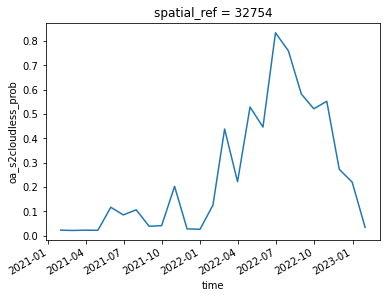

In [7]:
ds["oa_s2cloudless_prob"].mean(dim=['x', 'y']).resample(time='M').min().plot()

## Other bands

No real evidence of similar patterns in any of the other spectral bands:

In [8]:
load_params = dict(
    output_crs='epsg:32754',
    resolution=(-10, 10),
    group_by="solar_day",
    dask_chunks={},
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"],
)

ds = dc.load(**query_params, **load_params)
ds = mask_invalid_data(ds)
ds.load()

<xarray.Dataset>
Dimensions:       (time: 149, y: 227, x: 187)
Coordinates:
  * time          (time) datetime64[ns] 2021-01-01T00:46:58.906327 ... 2023-0...
  * y             (y) float64 6.064e+06 6.064e+06 ... 6.062e+06 6.062e+06
  * x             (x) float64 3.069e+05 3.069e+05 ... 3.088e+05 3.088e+05
    spatial_ref   int32 32754
Data variables:
    nbart_red     (time, y, x) float64 539.0 509.0 487.0 ... 1.935e+03 1.925e+03
    nbart_green   (time, y, x) float64 688.0 667.0 627.0 ... 2.019e+03 2.007e+03
    nbart_blue    (time, y, x) float64 554.0 537.0 525.0 ... 1.785e+03 1.818e+03
    nbart_nir_1   (time, y, x) float64 828.0 730.0 636.0 ... 2.05e+03 2.132e+03
    nbart_nir_2   (time, y, x) float64 870.0 870.0 696.0 ... 1.918e+03 1.861e+03
    nbart_swir_2  (time, y, x) float64 349.0 349.0 316.0 ... 1.928e+03 1.946e+03
    nbart_swir_3  (time, y, x) float64 256.0 256.0 228.0 ... 1.84e+03 1.783e+03
Attributes:
    crs:           epsg:32754
    grid_mapping:  spatial_ref

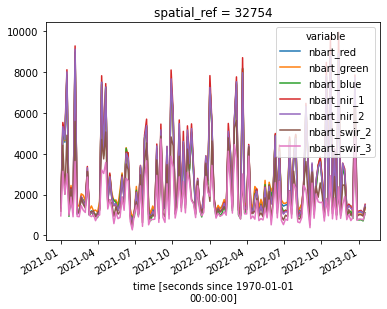

In [9]:
ds.mean(dim=['x', 'y']).to_array().plot.line(x='time');

## Theories/ideas
* Turbidity? But why does it respond to some flood plumes and not others?
* According to EUGL, s2cloudless is run against [Sentinel-2 Level 1C data that includes some bands (Band 9 Water Vapour, Band 10 Cirrus) that we don't include in our ARD](https://github.com/OpenDataCubePipelines/eugl/blob/master/eugl/s2cl.py#L13-L24) - could one of these bands have weird values in 2022 that explain the strange s2cloudless results?